In [1]:
# imports

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from confusion_matrix import ConfusionPlots
from torchvision import datasets, transforms

In [2]:
dir_path = '11_ds_2/'
class_names = np.load(dir_path+'class_names.npy')
orig_train_data = np.load(dir_path+'train_data.npy')
train_target = np.load(dir_path+'train_target.npy')
orig_test_data = np.load(dir_path+'test_data.npy')
test_target = np.load(dir_path+'test_target.npy')
print(np.shape(orig_train_data),np.shape(orig_test_data))
print(class_names)

(24000, 784) (6000, 784)
['Bag.csv' 'Coat.csv' 'Sandal.csv' 'Trouser.csv' 'T_shirt.csv']


In [3]:
def min_max_norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
print(np.max(orig_train_data))
train_data = min_max_norm(orig_train_data)
test_data = min_max_norm(orig_test_data)
print(np.max(train_data))

255.0
1.0


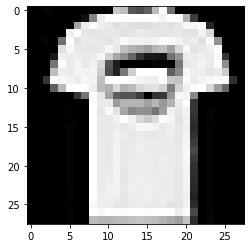

In [43]:
show_data = np.reshape(train_data[0],(28,28))
plt.imshow(show_data,cmap='gray')
plt.show()

In [4]:
class BB_RBM(nn.Module):

    def __init__(self, n_vis, n_hid, k):
        super(BB_RBM, self).__init__()
        self.v_bias = nn.Parameter(torch.zeros(1, n_vis))
        self.h_bias = nn.Parameter(torch.zeros(1, n_hid))
        self.weights = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def sample_hidden(self, v_prob):
        h_sig = torch.sigmoid(F.linear(v_prob, self.weights, self.h_bias)) # xA.T + b -> linear func
        return h_sig.bernoulli()

    def sample_visible(self, h_prob):
        v_sig = torch.sigmoid(F.linear(h_prob, self.weights.t(), self.v_bias))
        return v_sig.bernoulli()

    def free_energy(self, v_vals):
        v_term = torch.matmul(v_vals, self.v_bias.t())
        w_v_h = F.linear(v_vals, self.weights, self.h_bias)
        h_term = torch.sum(F.softplus(w_v_h), dim=1)
        return torch.mean(-h_term - v_term)
    
    def free_energy_gap(self, v_vals, v_gibbs):
        return self.free_energy(v_vals) - self.free_energy(v_gibbs)
    
    def k_step_contrasive_divergence(self, h_vals):
        for _ in range(self.k):
            v_gibbs = self.sample_visible(h_vals)
            h_vals = self.sample_hidden(v_gibbs)
        return v_gibbs, h_vals

    def forward(self, v_vals):
        h_vals = self.sample_hidden(v_vals)
        return v_vals, self.k_step_contrasive_divergence(h_vals)

In [36]:
# parameters

n_vis = 784
n_hid = 600
batch_size = 64
learning_rate = 0.001
num_epochs = 40
num_workers = 8
k = 3

# data loader

tensor_data = torch.Tensor(train_data)
tensor_data_test = torch.Tensor(test_data)

dataset = torch.utils.data.TensorDataset(tensor_data,tensor_data)
dataset_test = torch.utils.data.TensorDataset(tensor_data_test,tensor_data_test)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=num_workers)

bb_rbm1 = BB_RBM(n_vis,n_hid,k)
optimizer = optim.Adam(bb_rbm1.parameters(), lr=learning_rate)

# training

running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(loader):
        
        inputs, same_inputs = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        v_vals, (v_gibbs, _) = bb_rbm1(inputs.view(-1,n_vis))
        loss = bb_rbm1.free_energy_gap(v_vals,v_gibbs)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%1 == 0):
        print(epoch+1, running_loss/count)
        if running_loss < 0.1 and False:
            break
        running_loss = 0.0
        count = 0


1 1743.7360208333334
2 583.6362355957032
3 355.71903556315107
4 239.23721980794272
5 167.4538680419922
6 120.08111250813802
7 91.10377150472006
8 71.05243585205078
9 56.62479846191406
10 45.72814782714844
11 36.863215209960934
12 30.023254923502606
13 24.82463781738281
14 20.754005432128906
15 17.042563313802084
16 13.64575215657552
17 11.38003798421224
18 9.230260498046874
19 7.350568929036458
20 5.716765401204427
21 4.286522969563802
22 3.1980566609700523
23 2.0681763916015625
24 1.3068121744791668
25 0.6738294270833334
26 0.021629740397135416
27 -0.5891953938802084


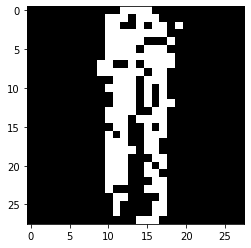

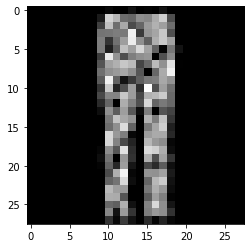

In [14]:
with torch.no_grad():
    v_vals,(v_gibbs,_) = bb_rbm1(torch.Tensor([train_data[50]]))
    plt.imshow(np.array(v_gibbs.view(-1, 1, 28, 28).data[0][0]),cmap='gray')
    plt.show()
    plt.imshow(np.array(v_vals.view(-1, 1, 28, 28).data[0][0]),cmap='gray')
    plt.show()

In [5]:
n_vis = 784
n_hid = 600
k = 3
bb_rbm1 = BB_RBM(n_vis,n_hid,k)
bb_rbm1.load_state_dict(torch.load('bbrbm1_task4.pth'))

<All keys matched successfully>

In [37]:
# computing error
error = 0
num = 0
with torch.no_grad():
    for data in loader:
        inputs, labels = data
        _,(outputs,_) = bb_rbm1(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Train error',end=':')
print(error/(num*n_vis))

error = 0
num = 0
with torch.no_grad():
    for data in loader_test:
        inputs, labels = data
        _,(outputs,_) = bb_rbm1(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Test error',end=':')
print(error/(num*n_vis))

Train error:10.566527748990222
Test error:10.654578635861343


In [38]:
torch.save(bb_rbm1.state_dict(),'bbrbm1_task4.pth')

In [44]:
# parameters

n_vis = 600
n_hid = 400
batch_size = 64
learning_rate = 0.001
num_epochs = 50
num_workers = 8
k = 3

# data loader

bbrbm_train = torch.Tensor(train_data)
bbrbm_test = torch.Tensor(test_data)

with torch.no_grad():
    print(bbrbm_train.size())
    _, (_,bbrbm1_train) = bb_rbm1(bbrbm_train)
    _, (_,bbrbm1_test) = bb_rbm1(bbrbm_test)
    print(bbrbm1_train.size())


dataset = torch.utils.data.TensorDataset(bbrbm1_train,bbrbm1_train)
dataset_test = torch.utils.data.TensorDataset(bbrbm1_test,bbrbm1_test)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=num_workers)

bb_rbm2 = BB_RBM(n_vis,n_hid,k)
optimizer = optim.Adam(bb_rbm2.parameters(), lr=learning_rate)

# training

running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(loader):
        
        inputs, same_inputs = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        v_vals, (v_gibbs, _) = bb_rbm2(inputs.view(-1,n_vis))
        loss = bb_rbm2.free_energy_gap(v_vals,v_gibbs)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%1 == 0):
        print(epoch+1, running_loss/count)
        if running_loss < 0.1:
            break
        running_loss = 0.0
        count = 0


torch.Size([24000, 784])
torch.Size([24000, 600])
1 776.4685105794271
2 10.553291341145833
3 6.826238606770834
4 4.791453287760417
5 3.3766778971354166
6 2.4587688802083334
7 1.7734168294270833
8 1.34162109375
9 1.0763255208333333
10 0.97965283203125
11 0.8423736979166667
12 0.72839892578125
13 0.6918839518229166
14 0.6235847981770833
15 0.5666223958333333
16 0.5242234700520834
17 0.5190032552083333
18 0.45929345703125
19 0.43380192057291667
20 0.41322542317708333
21 0.3932421875
22 0.37205533854166667
23 0.34519742838541667
24 0.32862060546875
25 0.2920372721354167
26 0.27357096354166666
27 0.27584114583333336
28 0.25465983072916665
29 0.233326171875
30 0.22042106119791666
31 0.21843863932291666
32 0.19878450520833332
33 0.1920419921875
34 0.1707607421875
35 0.189513671875
36 0.15502962239583334
37 0.16673225911458334
38 0.16107649739583332
39 0.14810221354166667
40 0.13839908854166666
41 0.13347884114583333
42 0.12963069661458335
43 0.13239518229166666
44 0.13470540364583333
45 0.129

In [ ]:
n_vis = 600
n_hid = 400
k = 3
bb_rbm2 = BB_RBM(n_vis,n_hid,k)
bb_rbm2.load_state_dict(torch.load('bbrbm2_task4.pth'))

In [48]:
# computing error
error = 0
num = 0
with torch.no_grad():
    for data in loader:
        inputs, labels = data
        _,(outputs,_) = bb_rbm2(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Train error',end=':')
print(error/(num*n_vis))

error = 0
num = 0
with torch.no_grad():
    for data in loader_test:
        inputs, labels = data
        _,(outputs,_) = bb_rbm2(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Test error',end=':')
print(error/(num*n_vis))

Train error:0.046275555555555556
Test error:0.05629432624113475


In [46]:
v_vals,(v_gibbs,_) = bb_rbm2(torch.Tensor(bbrbm1_train[0]))
plt.imshow(np.array(v_gibbs.view(-1, 1, 20, 30).data[0][0]),cmap='gray')
plt.show()
plt.imshow(np.array(v_vals.view(-1, 1, 20, 30).data[0][0]),cmap='gray')
plt.show()

ValueError: only one element tensors can be converted to Python scalars

In [49]:
torch.save(bb_rbm2.state_dict(),'bbrbm2_task4.pth')

In [52]:
# parameters

n_vis = 400
n_hid = 300
batch_size = 64
learning_rate = 0.001
num_epochs = 500
num_workers = 8
k = 3

# data loader

with torch.no_grad():
    print(bbrbm1_train.size())
    _, (_,bbrbm2_train) = bb_rbm2(bbrbm1_train)
    _, (_,bbrbm2_test) = bb_rbm2(bbrbm1_test)
    print(bbrbm2_train.size())


dataset = torch.utils.data.TensorDataset(bbrbm2_train,bbrbm2_train)
dataset_test = torch.utils.data.TensorDataset(bbrbm2_test,bbrbm2_test)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=num_workers)

bb_rbm3 = BB_RBM(n_vis,n_hid,k)
optimizer = optim.Adam(bb_rbm3.parameters(), lr=learning_rate)

# training

running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(loader):
        
        inputs, same_inputs = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        v_vals, (v_gibbs, _) = bb_rbm3(inputs.view(-1,n_vis))
        loss = bb_rbm3.free_energy_gap(v_vals,v_gibbs)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%10 == 0):
        print(epoch+1, running_loss/count)
        if running_loss < 0.1:
            break
        running_loss = 0.0
        count = 0


torch.Size([24000, 600])
torch.Size([24000, 400])
1 369.88730696614584
2 121.83973567708334
3 97.1497919921875
4 83.7075849609375
5 74.38709342447916
6 67.23411555989583
7 61.732060546875
8 56.73651888020834
9 52.69491927083333
10 48.981275065104164
11 45.62016438802083
12 42.763072265625
13 40.010018880208335
14 37.57530078125
15 35.581302083333334
16 33.411427083333336
17 31.510275065104167
18 29.673165690104167
19 28.21790462239583
20 26.627231770833333
21 25.140656575520833
22 23.8004189453125
23 22.607902018229165
24 21.468999674479168
25 20.53824609375
26 19.3809453125
27 18.438107421875
28 17.650585286458334
29 16.653310546875
30 15.940665364583333
31 15.1991318359375
32 14.412916015625
33 13.838484700520834
34 13.2892802734375
35 12.557130208333334
36 12.116829427083333
37 11.597724934895833
38 11.118968424479167
39 10.5729970703125
40 10.268253255208334
41 9.752364908854167
42 9.43082421875
43 9.062169921875
44 8.703986002604166
45 8.339358723958334
46 8.1025107421875
47 7.697

In [ ]:
n_vis = 400
n_hid = 300
k = 3
bb_rbm3 = BB_RBM(n_vis,n_hid,k)
bb_rbm3.load_state_dict(torch.load('bbrbm3_task4.pth'))

In [53]:
# computing error
error = 0
num = 0
with torch.no_grad():
    for data in loader:
        inputs, labels = data
        _,(outputs,_) = bb_rbm3(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Train error',end=':')
print(error/(num*n_vis))

error = 0
num = 0
with torch.no_grad():
    for data in loader_test:
        inputs, labels = data
        _,(outputs,_) = bb_rbm3(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Test error',end=':')
print(error/(num*n_vis))

Train error:7.708126666666667
Test error:7.752154255319149


In [ ]:
v_vals,(v_gibbs,_) = bb_rbm3(torch.Tensor([bbrbm2_train[0]]))
plt.imshow(np.array(v_gibbs.view(-1, 1, 28, 28).data[0][0]),cmap='gray')
plt.show()
plt.imshow(np.array(v_vals.view(-1, 1, 28, 28).data[0][0]),cmap='gray')
plt.show()

In [54]:
torch.save(bb_rbm3.state_dict(),'bbrbm3_task4.pth')

In [56]:
bb_rbm_train = torch.Tensor(train_data)
bb_rbm_test = torch.Tensor(test_data)

with torch.no_grad():
    print(bb_rbm_train.size())
    _, (_,bb_rbm_train) = bb_rbm1(bb_rbm_train)
    _, (_,bb_rbm_train) = bb_rbm2(bb_rbm_train)
    _, (_,bb_rbm_train) = bb_rbm3(bb_rbm_train)
    _, (_,bb_rbm_test) = bb_rbm1(bb_rbm_test)
    _, (_,bb_rbm_test) = bb_rbm2(bb_rbm_test)
    _, (_,bb_rbm_test) = bb_rbm3(bb_rbm_test)
    print(bb_rbm_train.size())

torch.Size([24000, 784])
torch.Size([24000, 300])


In [59]:
# parameters

dim = 300 # from output of aann2, 300
h1_dim = 50
h2_dim = 28
out_dim = len(class_names)
learning_rate = 0.001
momentum = 0.9
num_epochs = 1000
batch_size = 32  # general rule is to try 32, 64, 128 ... 

# DNN model with 2 fully connected hidden layers

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(dim,h1_dim) 
        self.fc2 = nn.Linear(h1_dim,h2_dim) 
        self.fc3 = nn.Linear(h2_dim,out_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
# loss fun and update method

tensor_train_target = torch.LongTensor(train_target) # long otherwise takes as float

tensor_test_target = torch.LongTensor(test_target)

# num_workers - how many parallel data loadings
train_dataset = torch.utils.data.TensorDataset(bb_rbm_train,tensor_train_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=8)

test_dataset = torch.utils.data.TensorDataset(bb_rbm_test,tensor_test_target)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=8)

net = DNN()
criterion = nn.CrossEntropyLoss()
# ASDG for generalised delta ig
# schochastic gradient descent with nestrov momentum
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = optim.Adagrad(net.parameters(), lr=learning_rate,lr_decay=0)

In [61]:
# training


running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(train_loader):
        
        inputs, labels = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%50 == 0):
        print(epoch+1, running_loss/count)
        running_loss = 0.0
        count = 0

50 0.6024029318459828
100 0.33399879946380856
150 0.3231111155334115
200 0.31509914469073214
250 0.30864865913028516
300 0.3047281931066513
350 0.3023192596764366
400 0.30065277444998423
450 0.29929413189907866
500 0.2982158507822454
550 0.2972033498770992
600 0.2963588753564159
650 0.2955019438078006
700 0.2946931361479064
750 0.29385866123477616
800 0.29309542581851283
850 0.29229061781302096
900 0.29147504007915653
950 0.2907523253694673
1000 0.28992709939097366


In [ ]:
net = DNN()
net.load_state_dict(torch.load('net_task4.pth'))

In [ ]:
# testing

# train data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('train accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task4-TrainData-3-Stacked-BBRBM',columns=class_names)

#test data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('test accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task4-TestData-3-Stacked-BBRBM',columns=class_names)

train accuracy:0.9040833333333333


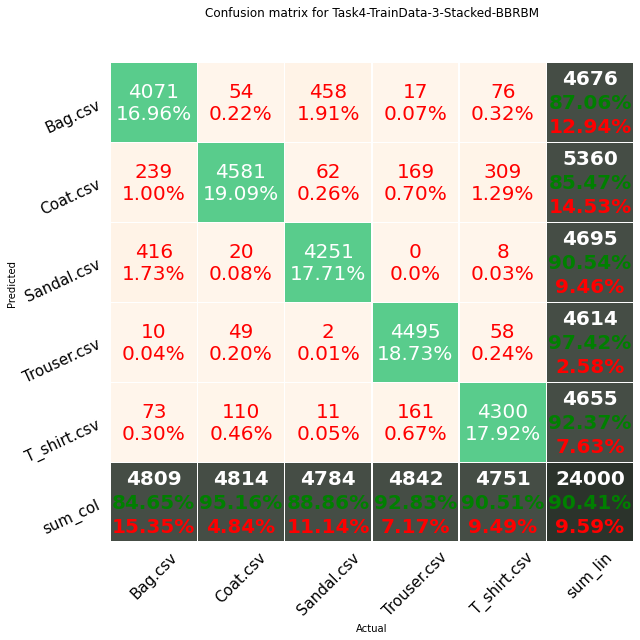

test accuracy:0.9018333333333334


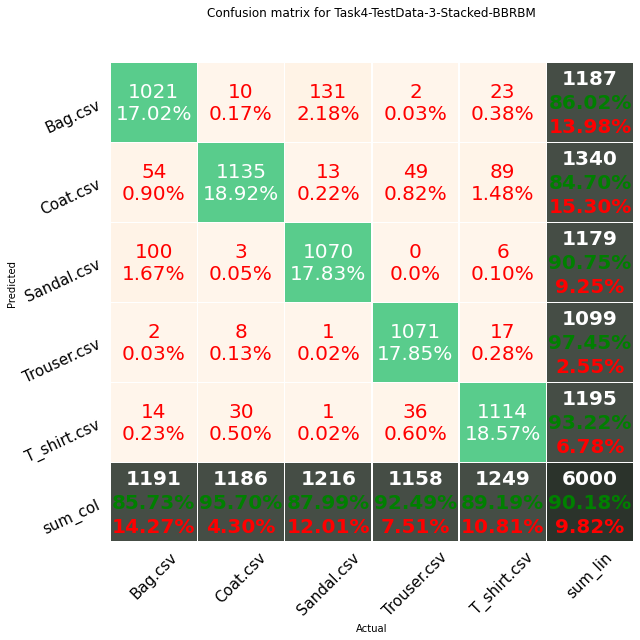

In [62]:
# testing

# train data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('train accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task4-TrainData-3-Stacked-BBRBM',columns=class_names)

#test data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('test accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task4-TestData-3-Stacked-BBRBM',columns=class_names)

In [63]:
torch.save(net.state_dict(),'net_task4.pth')